In [ ]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

## Google Sheet with past 350 days of Close Price of S&P 500 Tickers
# https://docs.google.com/spreadsheets/d/1ZuXWxrKsiymmyJ9w4gsQdtuCJwKNjPgipWNkRo05PP0/edit?usp=sharing

SHEET_ID  = "1ZuXWxrKsiymmyJ9w4gsQdtuCJwKNjPgipWNkRo05PP0"
TAB       = "Data"
FAST, SLOW = 50, 200
WINDOW_D   = 7

url  = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={TAB}"
raw = pd.read_csv(url, na_values=["#N/A"])

raw.rename(columns={raw.columns[0]: "Date"}, inplace=True)
raw["Date"] = pd.to_datetime(raw["Date"], errors="coerce", dayfirst=True)
raw = raw.dropna(subset=["Date"])

prices = (raw.set_index("Date")
            .apply(pd.to_numeric, errors="coerce")
            .dropna(axis=1, how="all")
            .sort_index()
            .ffill())                              # ← fill gaps

fast   = prices.rolling(FAST).mean()
slow   = prices.rolling(SLOW).mean()
cross  = (fast.shift(1) < slow.shift(1)) & (fast >= slow)

last   = cross.apply(lambda c: c[c].index[-1] if c.any() else pd.NaT)
cutoff = prices.index.max() - timedelta(days=WINDOW_D-1)
recent = last >= cutoff

summary = (pd.DataFrame({
            "Last Cross": last.dt.date,
            "Recent?": ["✅" if r else "" for r in recent]
        })
        .sort_values("Last Cross", ascending=False, na_position="last"))
print("\nSummary:")
summary.head(45)


Summary:


,Last Cross,Recent?
EQT,2025-11-07,✅
PCG,2025-11-07,✅
JBHT,2025-11-05,✅
LLY,2025-11-05,✅
MSCI,2025-11-04,✅
FDX,2025-10-29,
WAB,2025-10-27,
TECH,2025-10-27,
EG,2025-10-23,
MRK,2025-10-23,


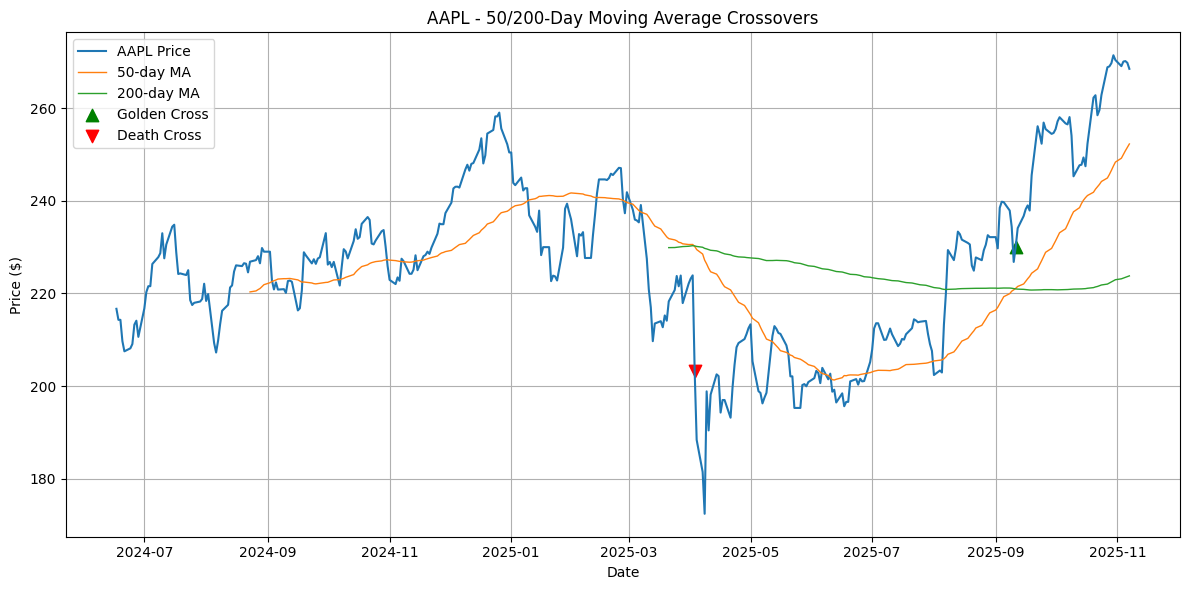

In [ ]:
ticker = "AAPL"  # change to any ticker symbol present in your sheet
if ticker in prices.columns:
    price = prices[ticker]
    fast_ma = price.rolling(FAST).mean()
    slow_ma = price.rolling(SLOW).mean()

    cross_up = (fast_ma.shift(1) < slow_ma.shift(1)) & (fast_ma >= slow_ma)
    cross_down = (fast_ma.shift(1) > slow_ma.shift(1)) & (fast_ma <= slow_ma)

    plt.figure(figsize=(12,6))
    plt.plot(price, label=f"{ticker} Price", linewidth=1.5)
    plt.plot(fast_ma, label=f"{FAST}-day MA", linewidth=1)
    plt.plot(slow_ma, label=f"{SLOW}-day MA", linewidth=1)
    plt.scatter(price.index[cross_up], price[cross_up], color='green', marker='^', s=80, label='Golden Cross')
    plt.scatter(price.index[cross_down], price[cross_down], color='red', marker='v', s=80, label='Death Cross')
    plt.title(f"{ticker} - {FAST}/{SLOW}-Day Moving Average Crossovers")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ Ticker '{ticker}' not found in sheet columns.")
